# Notebook 61: Using COMPAS's CosmicIntegration to compute CHE merger rates

In [4]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match 
# the first two digits in the notebook's title
nb_id = 61

## Imports

In [11]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, TwoSlopeNorm, to_rgba
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.integrate import quad
from scipy.stats import gaussian_kde

import sys
sys.path.append('..')
from src.util import Z_SUN, CODE_ROOT, DATA_ROOT

from cosmic_integration.cosmology import get_cosmology

In [12]:
cosmo = get_cosmology()
t_H = cosmo.age(0).to(u.yr).value

In [13]:
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)
plt.style.use('./plotstyle.mplstyle')

In [14]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

 ### Cosmic Integration functions (adapted)

## Computing

First we load the interpolated populations for fixed metallicities.

In [15]:
full_pop_fname = 'ip_pop_minz0.0005_maxz1.0_res1e+08_enhanced_w.npy'
merger_pop_fname = 'ip_pop_minz0.0005_maxz1.0_res1e+08_enhanced_w_mergers_only.npy'
full_arr = np.load(DATA_ROOT/full_pop_fname)
pop_arr = np.load(DATA_ROOT/merger_pop_fname)


In [16]:
full_arr.shape, pop_arr.shape

((1000000, 8), (9661, 8))

## Merger rates

We now define an adapted version of a function from CosmicIntegration.

In [17]:
from scipy.interpolate import interp1d

def find_formation_and_merger_rates(
    n_binaries, 
    redshifts, 
    times,
    time_first_SF,
    n_formed,
    dPdlogZ, 
    metallicities,
    p_draw_metallicity,
    COMPAS_metallicites,
    COMPAS_delay_times, 
    COMPAS_weights=None
    ):
    """
        Find the formation and merger rates per binary per redshift

        Args:
            n_binaries          --> [int] Number of DCO binaries in the arrays
            redshifts           --> [list of floats] Redshifts at which 
            to evaluate the rates
            times               --> [list of floats] Equivalent of the 
            redshifts in terms of age of the Universe
            n_formed            --> [float]          Binary formation 
            rate (number of binaries formed per year per cubic Gpc) 
            represented by each simulated COMPAS binary
            dPdlogZ             --> [2D float array] Probability of 
            getting a particular logZ at a certain redshift
            metallicities       --> [list of floats] Metallicities at 
            which dPdlogZ is evaluated; if this is None, assume that 
            metallicity weighting is 1 (corresponds to all SFR happening 
            at one fixed metallicity)
            p_draw_metallicity  --> [float]          Probability of 
            drawing a certain metallicity in COMPAS (float because 
            assuming uniform)
            COMPAS_metallicites --> [list of floats] Metallicity of each 
            binary in COMPAS data
            COMPAS_delay_times  --> [list of floats] Delay time of each 
            binary in COMPAS data
            COMPAS_weights      --> [list of floats] Adaptive sampling 
            weights for each binary in COMPAS data (defaults to all 1s 
            for unweighted samples)

        Returns:
            formation_rate      --> [2D float array] Formation rate for 
            each binary at each redshift
            merger_rate         --> [2D float array] Merger rate for 
            each binary at each redshift
    """
    
    # check if weights were provided, if not use uniform weights
    if COMPAS_weights is None:
        COMPAS_weights = np.ones(n_binaries)

    # initialise rates to zero
    n_redshifts = len(redshifts)
    redshift_step = redshifts[1] - redshifts[0]
    formation_rate = np.zeros(shape=(n_binaries, n_redshifts))
    merger_rate = np.zeros(shape=(n_binaries, n_redshifts))

    # interpolate times and redshifts for conversion
    times_to_redshifts = interp1d(times, redshifts)

    # make note of the first time at which star formation occurred
    age_first_sfr = time_first_SF

    # go through each binary in the COMPAS data
    for i in range(n_binaries):
        # if metallicities array is None, assume all SFR happened at one 
        # fixed metallicity
        if metallicities is None :
            formation_rate[i, :] = n_formed * COMPAS_weights[i]
        # calculate formation rate (see Neijssel+19 Section 4) - note 
        # this uses dPdlogZ for *closest* metallicity
        else:
            formation_rate[i, :] = (n_formed 
                                    * dPdlogZ[:, np.digitize(COMPAS_metallicites[i], metallicities)] 
                                    / p_draw_metallicity 
                                    * COMPAS_weights[i]
                                    )

        # calculate the time at which the binary formed if it merges at 
        # this redshift
        time_of_formation = times - COMPAS_delay_times[i]

        # we have only calculated formation rate up to z=max(redshifts),
        # so we need to only find merger rates for formation times at 
        # z<max(redshifts) first locate the index above which the binary 
        # would have formed before z=max(redshifts)
        first_too_early_index = np.digitize(age_first_sfr, time_of_formation)

        # include the whole array if digitize returns end of array and 
        # subtract one so we don't include the time past the limit
        first_too_early_index = (first_too_early_index + 1 
                                 if first_too_early_index == n_redshifts 
                                 else first_too_early_index)

        # as long as that doesn't preclude the whole range
        if first_too_early_index > 0:
            # work out the redshift at the time of formation
            z_of_formation = times_to_redshifts(time_of_formation[:first_too_early_index - 1])

            # calculate which index in the redshift array these 
            # edshifts correspond to
            z_of_formation_index = np.ceil(z_of_formation / redshift_step).astype(int)

            # set the merger rate at z (with z<10) to the formation rate
            # at z_form
            merger_rate[i, :first_too_early_index - 1] = formation_rate[i, z_of_formation_index]
    return formation_rate, merger_rate

In [18]:
from scipy.stats import norm as NormDist

def find_metallicity_distribution(redshifts, min_logZ_COMPAS, max_logZ_COMPAS,
                                  mu0=0.035, muz=-0.23, sigma_0=0.39, 
                                  sigma_z=0.0, alpha=0.0, min_logZ=-12.0, 
                                  max_logZ=0.0, step_logZ=0.01):
    """
    Calculate the distribution of metallicities at different redshifts 
    using a log skew normal distribution. The log-normal distribution 
    is a special case of this log skew normal distribution and is 
    retrieved by setting the skewness to zero (alpha=0). Based on the 
    method in Neijssel+19. Default values retrieve the dP/dZ 
    distribution used in Neijssel+19. See van Son+2022 for skewed 
    log-normal distribution.

    NOTE: This assumes that metallicities in COMPAS are drawn from a 
    flat-in-log distribution!

    Args:
        max_redshift       --> [float] Max redshift for calculation
        redshift_step      --> [float] Step used in redshift calculation
        min_logZ_COMPAS    --> [float] Min logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float] Max logZ value that COMPAS samples
        mu0                --> [float] Location (mean in normal) at z=0
        muz                --> [float] Redshift scaling of location
        sigma_0            --> [float] Scale (variance in normal) at z=0
        sigma_z            --> [float] Redshift scaling of the scale
        alpha              --> [float] Shape (skewness, alpha=0 gives 
                                  normal dist as in Neijssel+19)
        min_logZ           --> [float] Min logZ for dPdlogZ calculation
        max_logZ           --> [float] Max logZ for dPdlogZ calculation
        step_logZ          --> [float] Step size for logZ range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a 
                                  particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which 
                                  dPdlogZ is evaluated
        p_draw_metallicity --> [float] Probability of drawing a certain 
                                  metallicity in COMPAS
    """
    # Log-linear redshift dependence of sigma
    sigma = sigma_0 * 10**(sigma_z * redshifts)

    # Mean metallicities evolve with redshift (Langer & Norman 2006)
    mean_metallicities = mu0 * 10**(muz * redshifts)

    # Rewrite expected value of log-skew-normal to retrieve mu
    beta = alpha / (np.sqrt(1 + alpha**2))
    PHI = NormDist.cdf(beta * sigma)
    mu_metallicities = np.log(mean_metallicities / 2. / 
                              (np.exp(0.5 * sigma**2) * PHI))

    # Create a range of metallicities (x-values or random variables)
    log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
    metallicities = np.exp(log_metallicities)

    # Probabilities of log-skew-normal (without 1/Z factor)
    dPdlogZ = (2. / sigma[:, np.newaxis] * 
               NormDist.pdf((log_metallicities - mu_metallicities[:, np.newaxis]) / sigma[:, np.newaxis]) * 
               NormDist.cdf(alpha * (log_metallicities - mu_metallicities[:, np.newaxis]) / sigma[:, np.newaxis]))

    # Normalize distribution over all metallicities
    norm = dPdlogZ.sum(axis=-1) * step_logZ
    dPdlogZ = dPdlogZ / norm[:, np.newaxis]

    # Flat-in-log distribution for sampled metallicity in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)

    return dPdlogZ, metallicities, p_draw_metallicity


In [19]:
def calculate_redshift_related_params(max_redshift=10.0, max_redshift_detection=1.0, redshift_step=0.001, z_first_SF = 10.0, cosmology=None):
    """ 
        Given limits on the redshift, create an array of redshifts, times, distances and volumes

        Args:
            max_redshift           --> [float]          Maximum redshift to use for calculations
            max_redshift_detection --> [float]          Maximum redshift to calculate detection rates (must be <= max_redshift)
            redshift_step          --> [float]          size of step to take in redshift
            z_first_SF             --> [float]          redshift of first star formation

        Returns:
            redshifts              --> [list of floats] List of redshifts between limits supplied
            n_redshifts_detection  --> [int]            Number of redshifts in list that should be used to calculate detection rates
            times                  --> [list of floats] Equivalent of redshifts but converted to age of Universe
            distances              --> [list of floats] Equivalent of redshifts but converted to luminosity distances
            shell_volumes          --> [list of floats] Equivalent of redshifts but converted to shell volumes
    """
    cosmology = get_cosmology(cosmology)

    # create a list of redshifts and record lengths
    redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    n_redshifts_detection = int(max_redshift_detection / redshift_step)

    # convert redshifts to times and ensure all times are in Myr
    times = cosmology.age(redshifts).to(u.Myr).value

    # and time of first Sf
    time_first_SF = cosmology.age(z_first_SF).to(u.Myr).value

    # convert redshifts to distances and ensure all distances are in Mpc (also avoid D=0 because division by 0)
    distances = cosmology.luminosity_distance(redshifts).to(u.Mpc).value
    distances[0] = 0.001

    # convert redshifts to volumnes and ensure all volumes are in Gpc^3
    volumes = cosmology.comoving_volume(redshifts).to(u.Gpc**3).value

    # split volumes into shells and duplicate last shell to keep same length
    shell_volumes = np.diff(volumes)
    shell_volumes = np.append(shell_volumes, shell_volumes[-1])

    return redshifts, n_redshifts_detection, times, time_first_SF, distances, shell_volumes


In [20]:
max_redshift = 10.
max_redshift_detection = 1.
redshift_step = 0.01
z_first_SF = 10
cosmology = None

redshifts, n_redshifts_detection, times, time_first_SF, distances, shell_volumes = calculate_redshift_related_params(max_redshift, max_redshift_detection, redshift_step, z_first_SF, cosmology)
redshifts, n_redshifts_detection, times, time_first_SF, distances, shell_volumes

(array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ]),
 100,
 array([13786.88530201, 13643.42325365, 13502.04310818, ...,
          472.70613725,   472.05972595,   471.4147828 ]),
 471.41478279933636,
 array([1.00000000e-03, 4.46471061e+01, 8.99661301e+01, ...,
        1.05758633e+05, 1.05878879e+05, 1.05999136e+05]),
 array([3.61829883e-04, 2.51242457e-03, 6.75762957e-03, ...,
        2.53873901e+00, 2.53642410e+00, 2.53642410e+00]))

In [21]:
def find_sfr(redshifts, a = 0.01, b =2.77, c = 2.90, d = 4.70):
    """
        Calculate the star forming mass per unit volume per year following
        Neijssel+19 Eq. 6, using functional form of Madau & Dickinson 2014

        Args:
            redshifts --> [list of floats] List of redshifts at which to evaluate the sfr

        Returns:
            sfr       --> [list of floats] Star forming mass per unit volume per year for each redshift
    """
    # get value in mass per year per cubic Mpc and convert to per cubic Gpc then return
    sfr = a * ((1+redshifts)**b) / (1 + ((1+redshifts)/c)**d) * u.Msun / u.yr / u.Mpc**3
    return sfr.to(u.Msun / u.yr / u.Gpc**3).value

In [22]:
# Get star forming mass

@np.vectorize
def kroupa_imf(m):
    if m < 0.08:
        return 0.
    elif m < 0.5:
        return m**-1.3
    else:
        return m**-2.3 / 2

def get_m_frac(m_min, m_max):
    full_n = quad(kroupa_imf, 0.08, np.inf)[0]
    pop_n = quad(kroupa_imf, m_min, m_max)[0]
    return pop_n/full_n

def get_q_frac(q_min, q_max):
    return q_max - q_min

def get_p_frac(p_min, p_max):
    opik_min = 0.2
    opik_max = 3.2
    
    logp_min = np.log10(p_min)
    logp_max = np.log10(p_max)
    
    return (logp_max-logp_min)/(opik_max-opik_min)

binary_frac = 0.7

In [23]:
m_min = 30
m_max = 300
q_min = 0.7
q_max = 1.0
p_min = 10.**0.4
p_max = 10.**4.0

m_frac = get_m_frac(m_min, m_max)
q_frac = get_q_frac(q_min, q_max)
p_frac = get_p_frac(p_min, p_max)

total_frac = m_frac * q_frac * p_frac * (1-binary_frac)/binary_frac
m_sf_per_binary = full_arr[:,1].sum() / len(full_arr) / total_frac
m_sf_per_binary

163965.44632491356

In [24]:
aSF = 0.01
bSF = 2.77
cSF = 2.90
dSF = 4.70
sfr = find_sfr(redshifts, a = aSF, b = bSF, c = cSF, d = dSF) 

mass_evolved_per_binary = m_sf_per_binary
n_systems = len(pop_arr)
n_binaries = n_systems
average_sf_mass_needed = mass_evolved_per_binary * n_systems
n_formed = sfr/average_sf_mass_needed

min_Z = 0.1 * Z_SUN
max_Z = Z_SUN

# van Son et al. (2023) ApJ 948 105 Tab 1
mu0 = 0.025
muz = -0.049
sigma0 = 1.122
sigmaz = 0.049
alpha = -1.778
min_logZ = -12.0
max_logZ = 0.0
step_logZ = 0.01

dPdlogZ, metallicities, p_draw_metallicity = find_metallicity_distribution(
    redshifts=redshifts,
    min_logZ_COMPAS=np.log(min_Z),
    max_logZ_COMPAS=np.log(max_Z),
    mu0=mu0,
    muz=muz,
    sigma_0=sigma0,
    sigma_z=sigmaz,
    alpha=alpha,
    min_logZ=min_logZ,
    max_logZ=max_logZ,
    step_logZ=step_logZ
)

metallicitySystems = pop_arr[:, 0] * Z_SUN
delayTimes = 10.**pop_arr[:, -1]/1e6
delayTimes = np.where(np.isnan(delayTimes), 1e5, delayTimes)

formation_rate, merger_rate = find_formation_and_merger_rates(
    n_binaries=n_binaries,
    redshifts=redshifts,
    times=times,
    time_first_SF=time_first_SF,
    n_formed=n_formed,
    dPdlogZ=dPdlogZ,
    metallicities=metallicities,
    p_draw_metallicity=p_draw_metallicity,
    COMPAS_metallicites=metallicitySystems,
    COMPAS_delay_times=delayTimes,
    COMPAS_weights=None
)

In [25]:
dPdlogZ.shape

(1001, 1201)

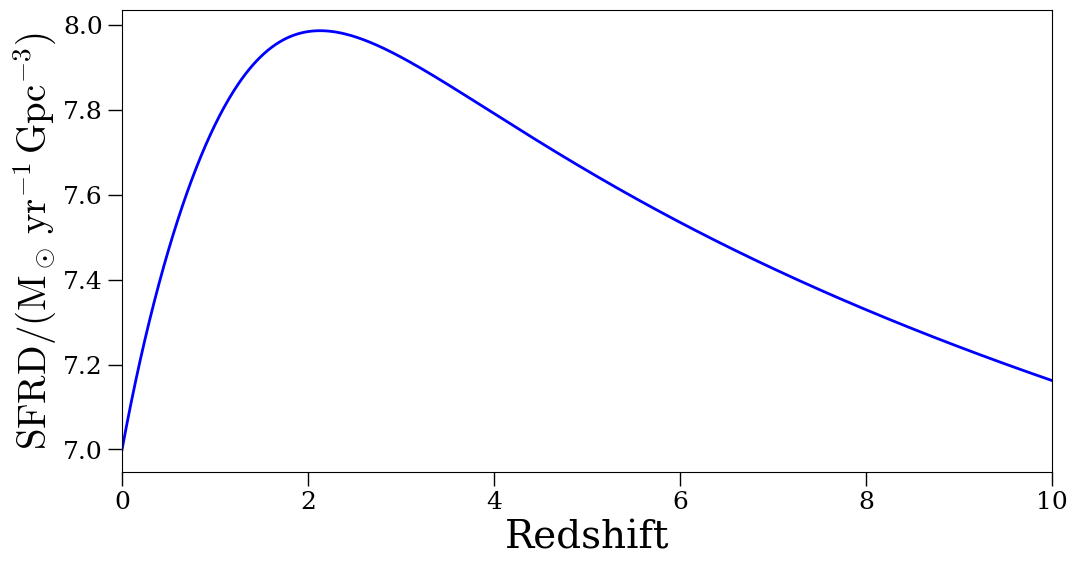

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(redshifts, np.log10(sfr), 'b-')
ax.set_ylabel('$\\mathrm{SFRD}/(\\mathrm{M}_\\odot\,\\mathrm{yr}^{-1}\,\\mathrm{Gpc}^{-3})$')
ax.set_xlabel('Redshift')
ax.set_xlim(0, 10)

savefig(fig, 'sfrd')

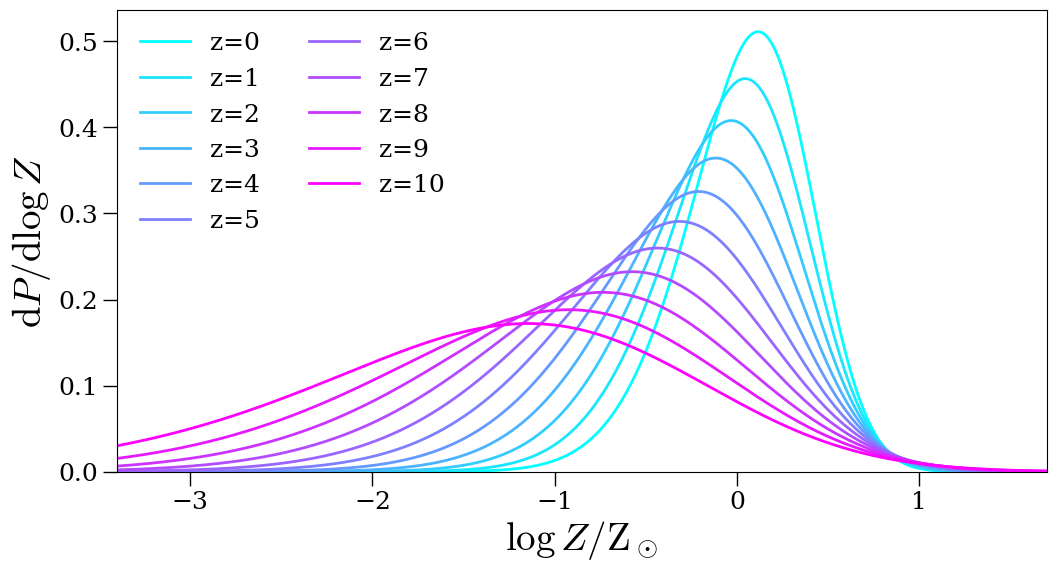

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(0, len(redshifts), 100):
    c = cm.cool(i/len(redshifts))
    ax.plot(np.log10(metallicities/Z_SUN), dPdlogZ[i], label=f'z={redshifts[i]:.0f}', c=c)
ax.legend(frameon=False, ncol=2, fontsize=18)
ax.set_xlabel('$\\log Z/\\mathrm{Z}_\\odot$')
ax.set_ylabel('$\\mathrm{d}P/\\mathrm{d}\\log Z$')
ax.set_xlim(-3.4, 1.7)
ax.set_ylim(0)
savefig(fig, 'metallicity_distribution')

Text(0.5, 1.0, 'Merger rate')

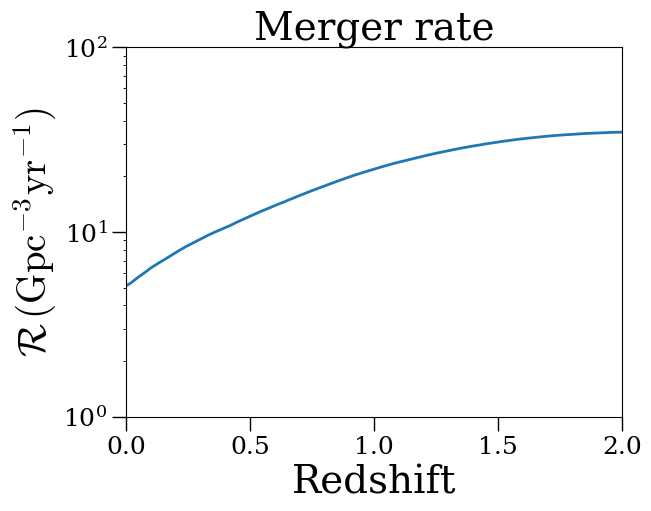

In [31]:
fig, ax = plt.subplots()

for rates in merger_rate:
    ax.plot(redshifts, rates, 'k-', lw=1, alpha=0.1)
ax.plot(redshifts, np.sum(merger_rate, axis=0))
ax.set_xlim(0,2)
ax.set_yscale('log')
ax.set_ylim(1, 100)

ax.set_xlabel('Redshift')
ax.set_ylabel('$\mathcal{R}\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_title('Merger rate')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


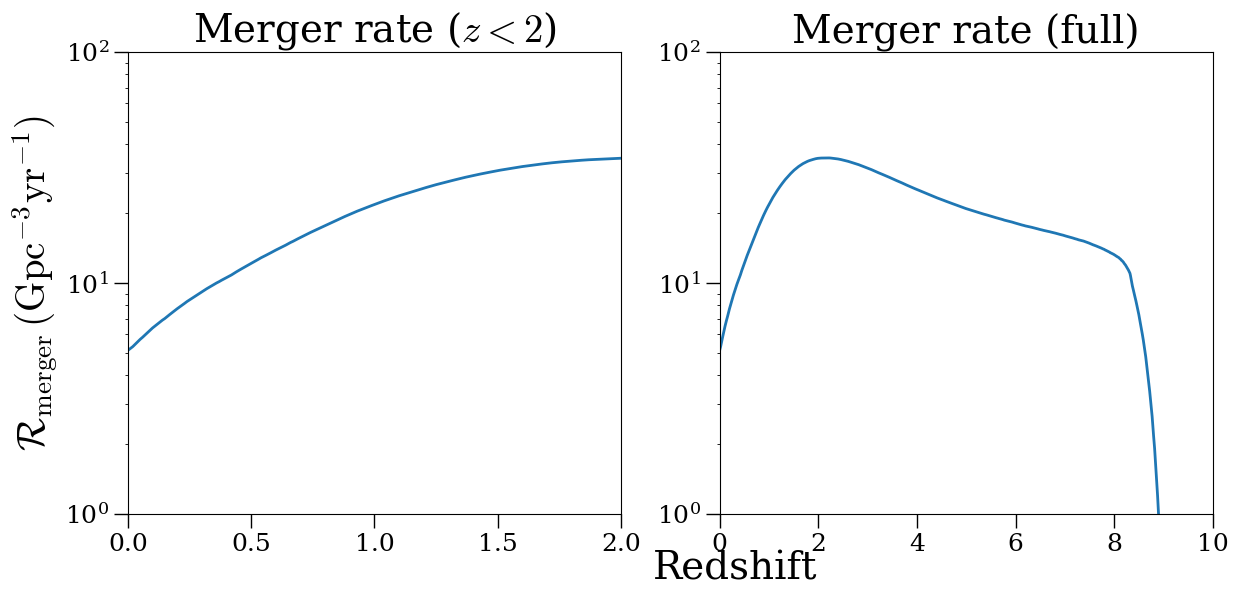

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax = axes[0]
for rates in merger_rate:
    ax.plot(redshifts, rates, 'k-', lw=1, alpha=0.1)
ax.plot(redshifts, np.sum(merger_rate, axis=0))
ax.set_xlim(0,2)
ax.set_yscale('log')
ax.set_ylim(1, 100)

ax = axes[1]
for rates in merger_rate:
    axes[0].plot(redshifts, rates, 'k-', lw=1, alpha=0.1)
ax.plot(redshifts, np.sum(merger_rate, axis=0))
ax.set_xlim(0,10)
ax.set_yscale('log')
ax.set_ylim(1, 100)

fig.text(0.5, 0, 'Redshift', transform=fig.transFigure)
axes[0].set_ylabel('$\mathcal{R}_\\mathrm{merger}\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
axes[0].set_title('Merger rate ($z<2$)')
axes[1].set_title('Merger rate (full)')

savefig(fig, 'merger_rate')

Text(0.5, 1.0, 'Formation rate')

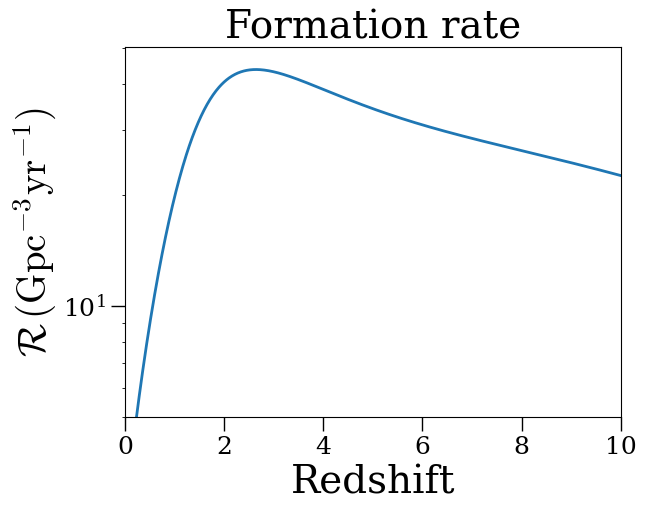

In [33]:
fig, ax = plt.subplots()

#for rates in formation_rate:
    #ax.plot(redshifts, rates, 'k-', lw=1, alpha=0.1)
ax.plot(redshifts, np.sum(formation_rate, axis=0))
ax.set_xlim(0,10)
ax.set_yscale('log')
ax.set_ylim(5)

ax.set_xlabel('Redshift')
ax.set_ylabel('$\mathcal{R}\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_title('Formation rate')

In [34]:
# Stolen from Lieke
def get_crude_rate_density(intrinsic_rate_density, fine_redshifts, crude_redshifts):
    """
        A function to take the 'volume averaged' intrinsic rate density for large (crude) redshift bins. 
        This takes into account the change in volume for different redshift shells

        !! This function assumes an integrer number of fine redshifts fit in a crude redshiftbin !!
        !! We also assume the fine redshift bins and crude redshift bins are spaced equally in redshift !!
        
        Args:
            intrinsic_rate_density    --> [2D float array] Intrinsic merger rate density for each binary at each redshift in 1/yr/Gpc^3
            fine_redshifts            --> [list of floats] Edges of redshift bins at which the rates where evaluated
            crude_redshifts           --> [list of floats] Merger rate for each binary at each redshift in 1/yr/Gpc^3

        Returns:
            crude_rate_density       --> [2D float array] Intrinsic merger rate density for each binary at new crude redshiftbins in 1/yr/Gpc^3

    """
    # Calculate the volume of the fine redshift bins
    fine_volumes       = cosmo.comoving_volume(fine_redshifts).to(u.Gpc**3).value
    fine_shell_volumes = np.diff(fine_volumes) #same len in z dimension as weight

    # Multiply intrinsic rate density by volume of the redshift shells, to get the number of merging BBHs in each z-bin
    N_BBH_in_z_bin         = (intrinsic_rate_density[:,:] * fine_shell_volumes[:])
    
    # !! the following asusmes your redshift bins are equally spaced in both cases!!
    # get the binsize of 
    fine_binsize, crude_binsize    = np.diff(fine_redshifts), np.diff(crude_redshifts) 
    if np.logical_and(np.all(np.round(fine_binsize,8) == fine_binsize[0]),  np.all(np.round(crude_binsize,8) == crude_binsize[0]) ):
        fine_binsize    = fine_binsize[0]
        crude_binsize   = crude_binsize[0] 
    else:
        print('Your fine redshifts or crude redshifts are not equally spaced!,',
              'fine_binsize:', fine_binsize, 'crude_binsize', crude_binsize)
        return -1

    # !! also check that your crude redshift bin is made up of an integer number of fine z-bins !!
    i_per_crude_bin = crude_binsize/fine_binsize 
    print('i_per_crude_bin', i_per_crude_bin)
    if (i_per_crude_bin).is_integer():
        i_per_crude_bin = int(i_per_crude_bin)
    else: 
        print('your crude redshift bin is NOT made up of an integer number of fine z-bins!: i_per_crude_bin,', i_per_crude_bin)
        return -1
    
    
    # add every i_per_crude_bin-th element together, to get the number of merging BBHs in each crude redshift bin
    N_BBH_in_crudez_bin    = np.add.reduceat(N_BBH_in_z_bin, np.arange(0, len(N_BBH_in_z_bin[0,:]), int(i_per_crude_bin) ), axis = 1)
    
    
    # Convert crude redshift bins to volumnes and ensure all volumes are in Gpc^3
    crude_volumes       = cosmo.comoving_volume(crude_redshifts).to(u.Gpc**3).value
    crude_shell_volumes = np.diff(crude_volumes)# split volumes into shells 
    
    
    # Finally tunr rate back into an average (crude) rate density, by dividing by the new z-volumes
    # In case your crude redshifts don't go all the way to z_first_SF, just use N_BBH_in_crudez_bin up to len(crude_shell_volumes)
    crude_rate_density     = N_BBH_in_crudez_bin[:, :len(crude_shell_volumes)]/crude_shell_volumes
    
    return crude_rate_density

In [63]:
step = np.diff(redshifts)[0]/2
fine_redshift_bins = np.arange(0-step, 10+step*2, step)[::2]

In [64]:
z_range = np.arange(0, 11, 1)
all_merger_crude_rate = get_crude_rate_density(merger_rate, fine_redshift_bins, z_range)

i_per_crude_bin 100.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


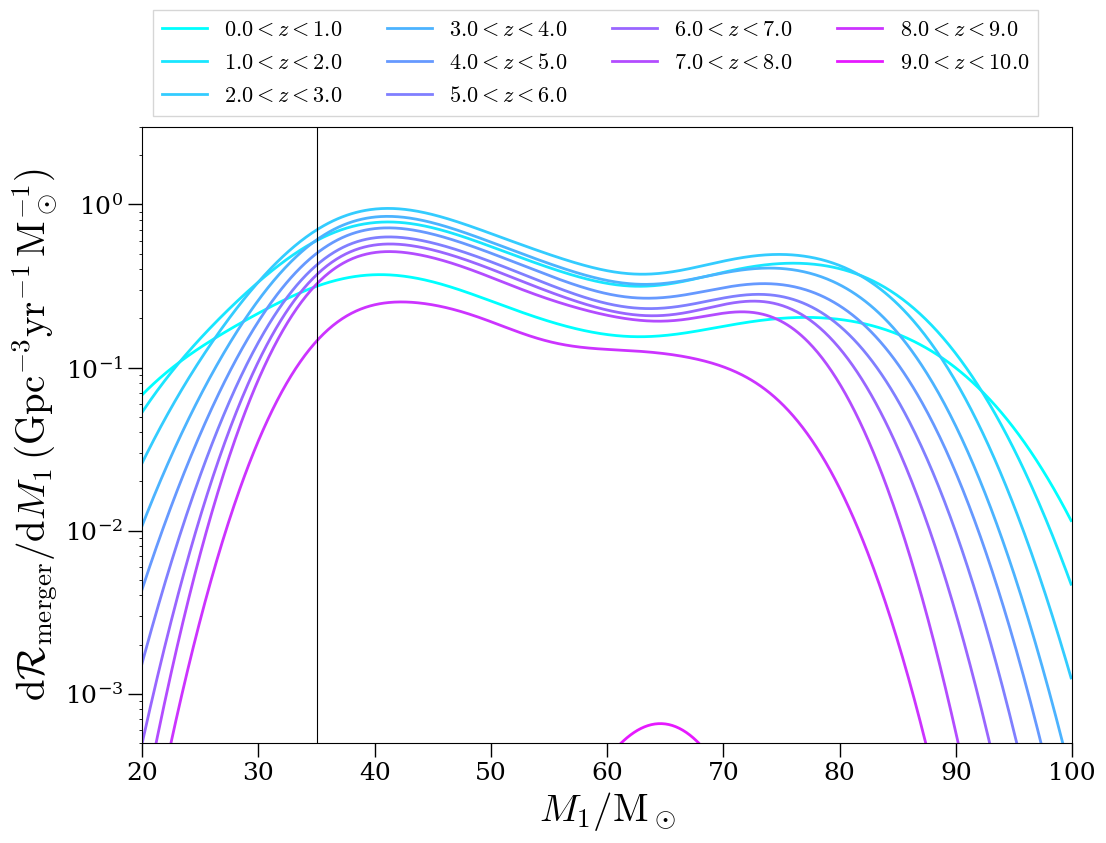

In [65]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_merger_crude_rate[:,i]
    indv_masses = pop_arr[:, 3]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.3)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(9, 100, 0.1)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')

ax.set_xlabel('$M_1/\mathrm{M}_\odot$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\mathrm{merger}/\mathrm{d}M_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1}\,\mathrm{M}_\odot^{-1})$')
ax.set_yscale('log')
ax.set_xlim(20, 100)
ax.set_ylim(5e-4, 3e0)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)
ax.vlines(35, 1e-5, 1e1, color='k', lw=0.8)

savefig(fig, 'mass_mrates')
        

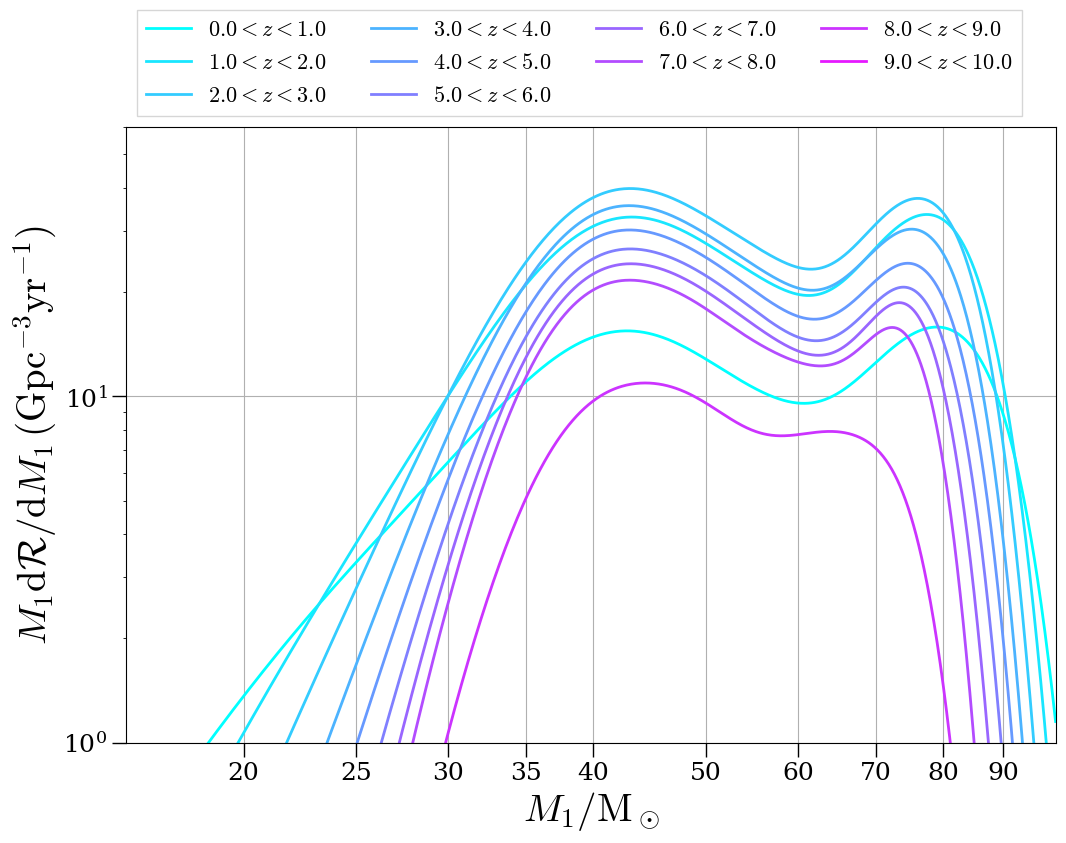

In [66]:
fig, ax = plt.subplots(figsize=(12,8))
ax.grid(True, which='major', axis='y')
ax.grid(True, which='both', axis='x')

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_merger_crude_rate[:,i]
    indv_masses = pop_arr[:, 3]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.3)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(9, 100, 0.1)
        plot_y = kde.evaluate(plot_x) * sum(hist) * plot_x
        
        ax.plot(np.log10(plot_x), plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')

ax.set_xlabel('$M_1/\mathrm{M}_\odot$')
ax.set_ylabel('$M_1\mathrm{d}\mathcal{R}/\mathrm{d}M_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(1.2, 2)
xticks = np.log10(np.array([20, 25, 30, 35, 40, 50, 60, 70, 80, 90]))
ax.set_xticks(xticks)
ax.set_xticklabels([f'{10**x:.0f}' for x in xticks])


ax.set_ylim(1e0, 6e1)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)
#ax.vlines(35, 1e-5, 1e1, color='k', lw=0.8)
#ax.set_xscale('log')
#savefig(fig, 'mass_mrates')
        

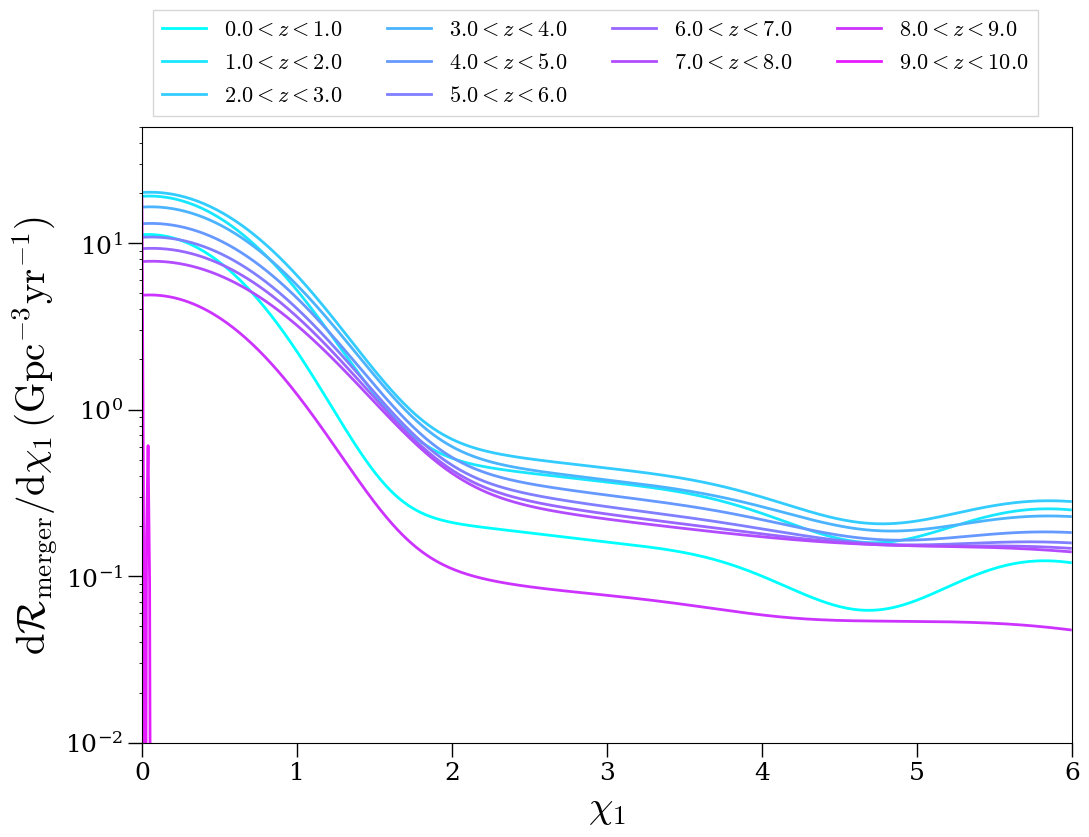

In [68]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_merger_crude_rate[:,i][~np.isnan(pop_arr[:, 6])]
    indv_masses = pop_arr[:, 6][~np.isnan(pop_arr[:, 6])]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.4)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(0, 6, 0.01)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')
        

ax.set_xlabel('$\chi_1$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\\mathrm{merger}/\mathrm{d}\chi_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(0, 6)
ax.set_ylim(0.01, 50)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)

#savefig(fig, 'a_mrates')
        

In [43]:
import h5py

bump_data  = h5py.File(DATA_ROOT/'35peak_m1_data.h5', 'r')

In [44]:
bump_data.keys()

<KeysViewHDF5 ['ms', 'q10', 'q50', 'q90']>

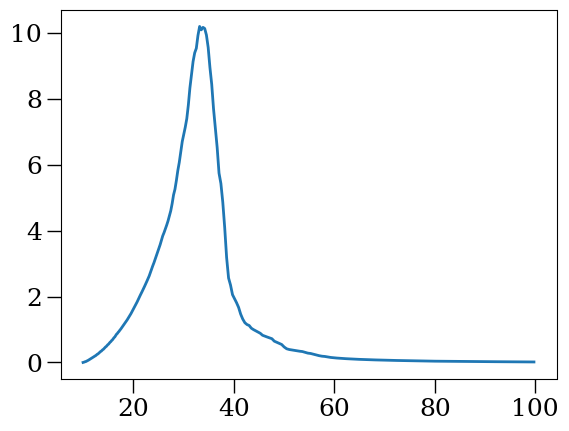

In [45]:
plt.plot(np.array(bump_data['ms']), np.array(bump_data['q10']))

In [69]:
step = np.diff(redshifts)[0]/2
fine_redshift_bins = np.arange(0-step, 10+step*2, step)[::2]

In [70]:
z_range = np.arange(0, 11, 0.5)
all_merger_crude_rate = get_crude_rate_density(merger_rate, fine_redshift_bins, z_range)

i_per_crude_bin 50.0


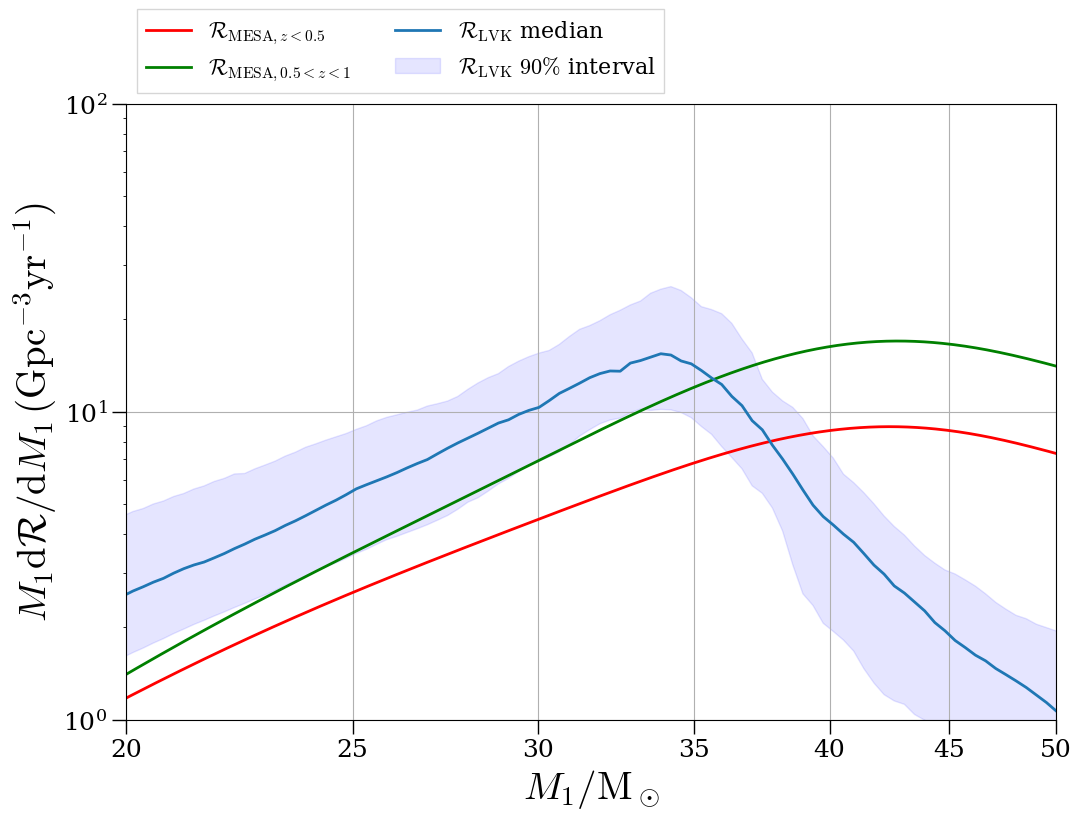

In [71]:
fig, ax = plt.subplots(figsize=(12,8))
ax.grid(True, which='major', axis='y')
ax.grid(True, which='both', axis='x')

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_merger_crude_rate[:,i]
    indv_masses = pop_arr[:, 3]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.3)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(9, 100, 0.1)
        plot_y = kde.evaluate(plot_x) * sum(hist) * plot_x
        
        if i == 0:
            ax.plot(np.log10(plot_x), plot_y, c='r', label='$\mathcal{R}_{\mathrm{MESA},z<0.5}$')
        else:
            ax.plot(np.log10(plot_x), plot_y, c='g', label='$\mathcal{R}_{\mathrm{MESA},0.5<z<1}$')
        
    if i == 1:
        break


ax.plot(np.log10(bump_data['ms']), np.array(bump_data['q50']), label='$\mathcal{R}_\mathrm{LVK}$ median')
ax.fill_between(np.log10(bump_data['ms']), np.array(bump_data['q10']), np.array(bump_data['q90']), alpha=0.1, color='b', label='$\mathcal{R}_\mathrm{LVK}$ $90\%$ interval')

ax.set_xlabel('$M_1/\mathrm{M}_\odot$')
ax.set_ylabel('$M_1\mathrm{d}\mathcal{R}/\mathrm{d}M_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(np.log10(20), np.log10(50))
xticks = np.log10(np.array([20, 25, 30, 35, 40, 45, 50]))
ax.set_xticks(xticks)
ax.set_xticklabels([f'{10**x:.0f}' for x in xticks])


ax.set_ylim(1e0, 1e2)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=2, fontsize=16)
#ax.vlines(35, 1e-5, 1e1, color='k', lw=0.8)
#ax.set_xscale('log')
#savefig(fig, 'mass_mrates')
        

19
20


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


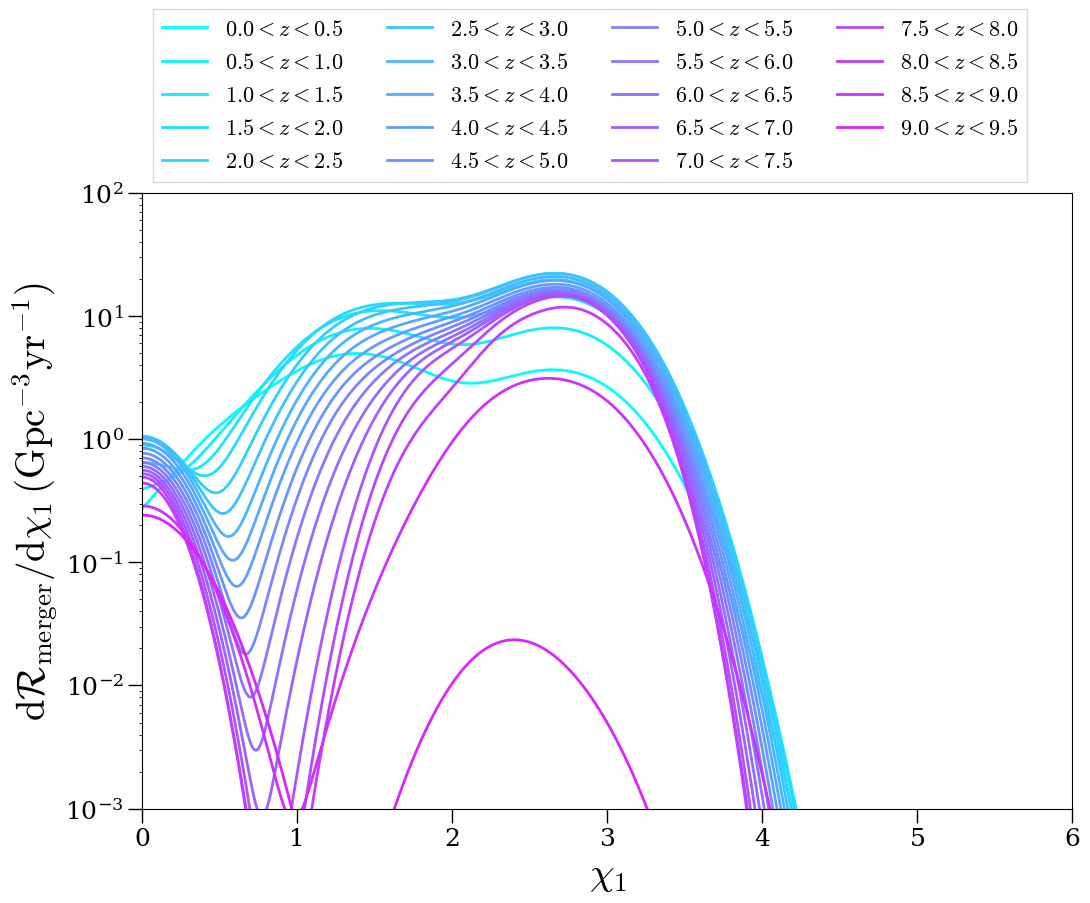

In [50]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_merger_crude_rate[:,i]
    indv_masses = pop_arr[:, 5]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.4)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(0, 6, 0.01)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')

ax.set_xlabel('$\chi_1$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\\mathrm{merger}/\mathrm{d}\chi_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(0, 6)
ax.set_ylim(0.001, 100)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)

savefig(fig, 'a_mrates')
        

In [53]:
pop_arr.shape

(9661, 8)

In [56]:
indv_rates.shape

(9661,)

19
20


/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/scipy/stats/_kde.py:208: RuntimeWarning: invalid value encountered in divide
  self._weights /= sum(self._weights)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


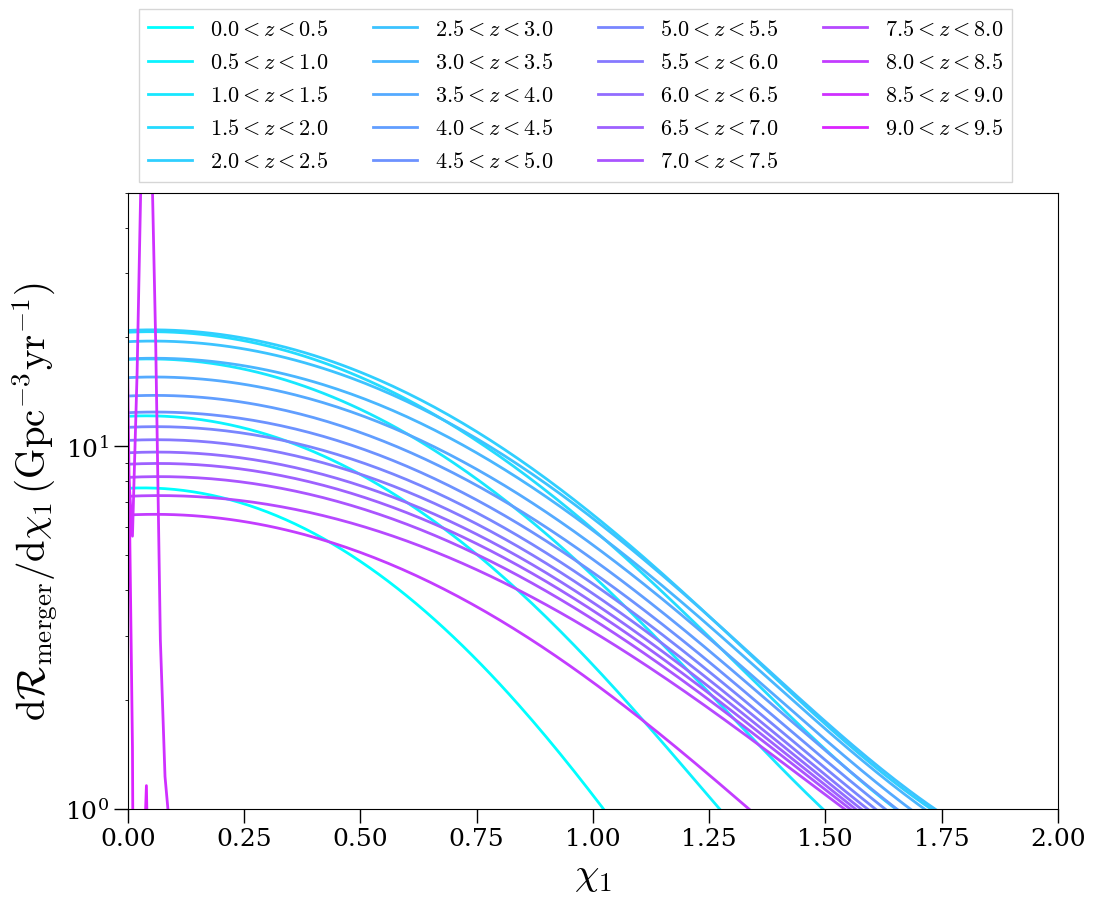

In [62]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_merger_crude_rate[:,i][~np.isnan(pop_arr[:, 6])]
    indv_masses = pop_arr[:, 6][~np.isnan(pop_arr[:, 6])]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.4)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(0, 6, 0.01)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')
        

ax.set_xlabel('$\chi_1$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\\mathrm{merger}/\mathrm{d}\chi_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(0, 2)
ax.set_ylim(1, 50)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)

savefig(fig, 'a_mrates')
        

In [ ]:
step = np.diff(redshifts)[0]/2
fine_redshift_bins = np.arange(0-step, 10+step*2, step)[::2]

In [ ]:
z_range = np.arange(0, 11, 1)
all_form_crude_rate = get_crude_rate_density(formation_rate, fine_redshift_bins, z_range)

i_per_crude_bin 100.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


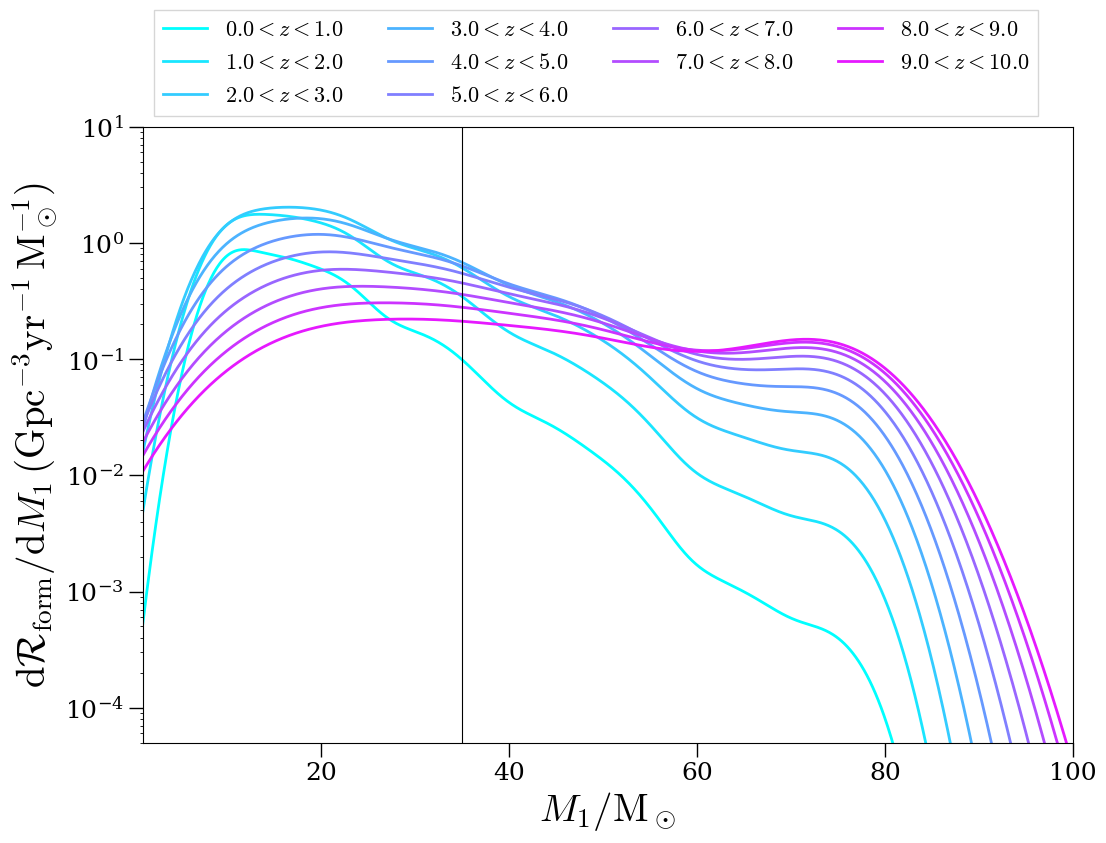

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_form_crude_rate[:,i]
    indv_masses = pop_arr[:, 3]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.3)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(1, 100, 0.1)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')

ax.set_xlabel('$M_1/\mathrm{M}_\odot$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\\mathrm{form}/\mathrm{d}M_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1}\,\mathrm{M}_\odot^{-1})$')
ax.set_yscale('log')
ax.set_xlim(1, 100)
ax.set_ylim(5e-5, 1e1)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)
ax.vlines(35, 1e-5, 1e1, color='k', lw=0.8)

savefig(fig, 'mass_frates')
        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


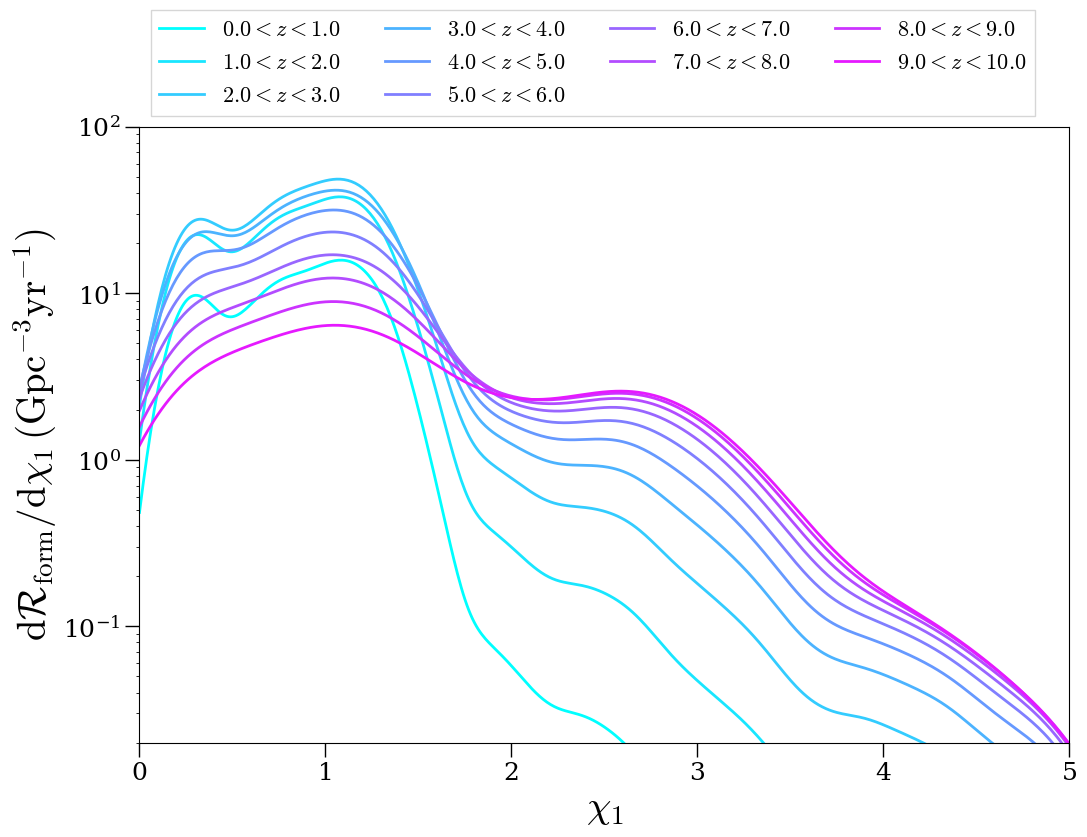

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_form_crude_rate[:,i]
    indv_masses = pop_arr[:, 5]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.3)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(0, 5.1, 0.01)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')

ax.set_xlabel('$\chi_1$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\\mathrm{form}/\mathrm{d}\chi_1\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(0, 5)
ax.set_ylim(2e-2, 1e2)
ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16)
ax.vlines(35, 1e-5, 1e1, color='k', lw=0.8)

savefig(fig, 'a_frates')
        

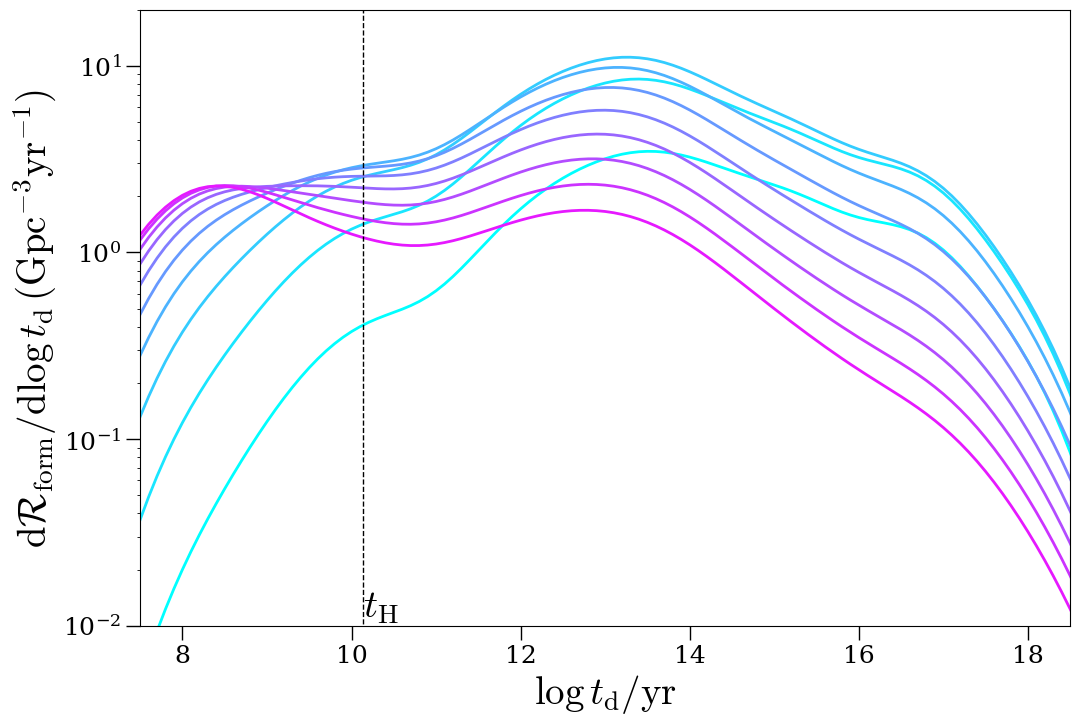

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))

for i in range(len(z_range)-1):
    c = cm.cool(i/(len(z_range)-1))
    indv_rates = all_form_crude_rate[:,i]
    indv_masses = pop_arr[:, -1]

    hist, bins = np.histogram(indv_masses, weights=indv_rates, bins=100)
    #ax.stairs(hist,bins)
    try:
        kde = gaussian_kde(indv_masses, weights=indv_rates, bw_method=0.3)
    except:
        print(i)
        continue
    else:
        norm = sum(hist)

        plot_x = np.arange(1, 100, 0.1)
        plot_y = kde.evaluate(plot_x) * sum(hist)
        
        ax.plot(plot_x, plot_y, c=c, label=f'${z_range[i]:.1f} < z < {z_range[i+1]:.1f}$')

ax.set_xlabel('$\\log t_\\mathrm{d}/\mathrm{yr}$')
ax.set_ylabel('$\mathrm{d}\mathcal{R}_\\mathrm{form}/\mathrm{d}\\log t_\\mathrm{d}\,(\mathrm{Gpc}^{-3} \mathrm{yr}^{-1})$')
ax.set_yscale('log')
ax.set_xlim(5, 20)
ax.set_ylim(1e-2, 2e1)
ax.vlines(np.log10(t_H), 0, 90, color='k', ls='--', lw=1)
ax.text(np.log10(t_H), 1e-2, '$t_\mathrm{H}$', color='k', ha='left', va='bottom')
#ax.legend(frameon=True, fancybox=False, loc='lower left', bbox_to_anchor=(0, 1), ncol=4, fontsize=16 )
ax.vlines(35, 1e-5, 1e1, color='k', lw=0.8)
ax.set_xlim(7.5, 18.5)

savefig(fig, 'td_frates')
        